# HEART RATE ESTIMATION

Seismocardiography([SCG](https://www.ncbi.nlm.nih.gov/pubmed/24111357)) is a very promising technique to measure Heart Rate (HR) and Respiratory Rate (RR) with the detector positioned above sternum. It is generally based on accelerometer and gyroscope readings or a combination of them. 

Ballistocardiography([BCG](https://en.wikipedia.org/wiki/Ballistocardiography)) is an another technique to estimate heart and respiratory rate with combination of both accelerometer and gyroscope. It is an indirect evaluation of HR and RR since the contact between the device and the body of the subject is not required (e.g., accelerometer platform mounted under the slats of the bed).   
  
MuSe(Multi-Sensor miniaturized, low-power, wireless [IMU](https://en.wikipedia.org/wiki/Inertial_measurement_unit)) is an Inertial Measurement Unit (IMU) provide by [221e](https://www.221e.com). In the context of this project, It allows to record the inertial data necessary for the estimation of SCG and BCG.

The goal of this assignment is to estimate the heart rate of an healthy subject, given linear acceleration and angular velocity measurements recorded by using the aforementioned MuSe platform. 
The study must be performed on two datasets: the first is the compulsory one (**center_sternum.txt**) while the second is left at the discretion of the group, among those made available for the assignment.

**N.B: Remember that normal beat is around [40-100] bpm.**


## Dataset

The data is provided in .txt file. During this study two healthy subjects were involved with their informed consent. The first dataset was recorded on one subject, while all the other datasets were recorded on the second subject. 

This is the first mandatory file:

* **center_sternum.txt**: MuSe placed on the center of the sternum. The subject was lying supine on his left and right side, respectively. 


Choose one of the following files in order to complete the task.

1. **1_Stave_supine_static.txt**: Sensor placed on a bed stave, under the mattress at the level of the chest. The subject was lying supine on his left and right side. 
* **2_Mattress_supine.txt**: Sensor placed on the mattress, near one corner but not under the pillow. The subject laid in the same position as above. 
* **3_Subject_sitting_chair.txt**: Sensor placed on the desk: the subject, sitting on a chair, leaned forearms and hands on the desk. 
* **4_Chest_sweater.txt**: Sensor placed on the subject chest directly on a sweater. 
* **5_Under_chair.txt**: Subject sitting on a chair, sensor placed under the seat of the chair. 

All .txt files give 16 columns index, in particular: 

* Log Freq stands for the acquisition  in Hz (i.e., sampling interval is constant).
* AccX, AccY, AccZ are the measured magnitude of linear acceleration along each axis.
* GyroX, GyroY, GyroZ are the measured magnitude of angular velocity along each axis.
* MagnX, MagnY, MagnZ are the measured magnitude of magnetic field along each axis.
* qw, qi, qj, qk are the quaternion components, representing the spatial orientation of the Muse system.

Each dataset includes, in addition to the data, one file containing the adopted configuration of the MuSe(**README1.txt** for the first measurement, and in **README_5.txt** for the other measurement).
 


## Assignment



1. Data preparation:

    1.1. Load the txt file and select only the columns you are interesting in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )
    
    1.2. Plot selected data in function of time and choose a properly time window over which to perform the analysis. Pay attention on time rappresentation and the measurament unit.
    
    1.3. In order to make an appropiate work, decide if take care about some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.  


    
2. Time and frequency analysis:

    2.1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.
    
    2.2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use this step in order to properly design the filters in the following step. 



3. Filter:
    
    Implement your own filter, trying to extrapolate heart rate signal. Hint:
    
    (a) Directly from Fourier Analysis, antitrasform data looking for the most interesting frequency band.
    
    (b) Choose the appropriate Lowpass/Bandpass/Highpass filter.
    
    (c) Wavelet trasform (a powerfull instrument that make a time and frequency analysis of signal).
    
    (d) Find another method by yourselves.
    
    Motivate your choice.
    
    
4. Metrics:

    4.1. Heart Beat Per Minute(BPM): extrapolate BPM, make an histogram of the result. Does it follow a partiular distribution? 
    
    4.2. Heart Rate Variability(HRV): extrapolate HRV, explain why this parameter is important, and plot the results.



5. (OPTIONAL) Algorithm: Elaborate a simple algorithm to extrapolate heart beat even when filter failed (e.g. look at particular threshold...).  



6. Conclusion: 

    Summarise the obtained results, in particular making a comparison between the two files analysed. Highlight limitation and critical issues encountered during the work, motivating the most relevant contribution given by your solution.




**N.B: Indicate the contribution, to achieving the result, of each member of the group.**


## Load the required packages

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
#empty cell, do not delete, just edit

In [3]:
#empty cell, do not delete, just edit

In [4]:
#empty cell, do not delete, just edit

## Read the data and correct it with respect to the calibration

In these cells I read the data w.r.t. the calibration and i've added a time column (by taking steps of 1/samplingfrequency)

In [5]:
# Load the datafile
datafile = pd.read_csv('center_sternum.txt',sep='\t')

# Look what our data is like in order to select useful columns
print("The variables in our datafile are:", datafile.columns)
print("The size of our datafile is", datafile.shape)

The variables in our datafile are: Index(['Log Mode', 'Log Freq', 'Timestamp', 'AccX', 'AccY', 'AccZ', 'GyroX',
       'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ', 'qw', 'qi', 'qj', 'qk'],
      dtype='object')
The size of our datafile is (16506, 16)


In [6]:
# Drop not needed columns
df = datafile.drop(['qw', 'qi', 'qj', 'qk'], axis = 1)

# This data isn't correct, needs to be calibrated

gyro_offset = np.array([-2.242224,2.963463,-0.718397])
acc_calibration = np.array([[1.000966,-0.002326418,-0.0006995499],
                    [-0.002326379,0.9787045,-0.001540918],
                    [-0.0006995811,-0.001540928,1.00403]])
acc_offset = np.array([-3.929942,-13.74679,60.67546])
magn_calibration = np.array([[0.9192851,-0.02325168,0.003480837],
                   [-0.02325175,0.914876,0.004257396],
                   [0.003481006,0.004257583,0.8748001]])
magn_offset = np.array([-95.67974,-244.9142,17.71132])

df[['GyroX','GyroY','GyroZ']] = df[['GyroX','GyroY','GyroZ']] + gyro_offset.T
df[['AccX','AccY','AccZ']] = np.dot(df[['AccX','AccY','AccZ']],acc_calibration.T) + acc_offset.T
df[['MagnX','MagnY','MagnZ']] = np.dot(df[['MagnX','MagnY','MagnZ']],magn_calibration.T) + magn_offset.T

#Add time column by taking time steps of 1/logFreq
df['Time'] = np.arange(0, len(df['Log Freq']))/df['Log Freq'][0]
display(df)

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
0,5,200,1576222772,943.007996,410.325442,130.264244,-9.066652,-11.280817,0.686183,-502.261441,-683.404962,-141.669690,0.000
1,5,200,1576222772,965.209969,363.380701,148.635086,3.940982,-9.326617,-8.687863,-502.257960,-683.400705,-140.794890,0.005
2,5,200,1576222772,985.689106,356.065246,138.465450,9.467696,-1.998369,-8.168779,-502.257960,-683.400705,-140.794890,0.010
3,5,200,1576222772,950.852176,393.026437,148.047237,15.635636,5.482547,-6.703130,-502.207976,-685.226199,-139.928605,0.015
4,5,200,1576222772,968.040164,402.461108,159.595720,22.979146,8.368043,3.296870,-502.207976,-685.226199,-139.928605,0.020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16501,5,200,1576222847,954.849739,269.000099,5.047576,-0.578102,5.268807,-1.390153,-539.805161,-644.743591,-96.144764,82.505
16502,5,200,1576222847,951.006879,266.016847,9.709647,-0.761308,5.452013,-1.420687,-539.778428,-645.654210,-95.274222,82.510
16503,5,200,1576222847,963.711402,268.397270,-4.573267,-1.127720,6.337509,-1.619160,-539.778428,-645.654210,-95.274222,82.515
16504,5,200,1576222847,961.972293,278.538659,3.067677,-1.539934,6.627585,-2.306183,-540.740736,-643.796949,-94.394388,82.520


In [7]:
#empty cell, do not delete, just edit

In [8]:
#empty cell, do not delete, just edit

## Plot the data and choose time frame

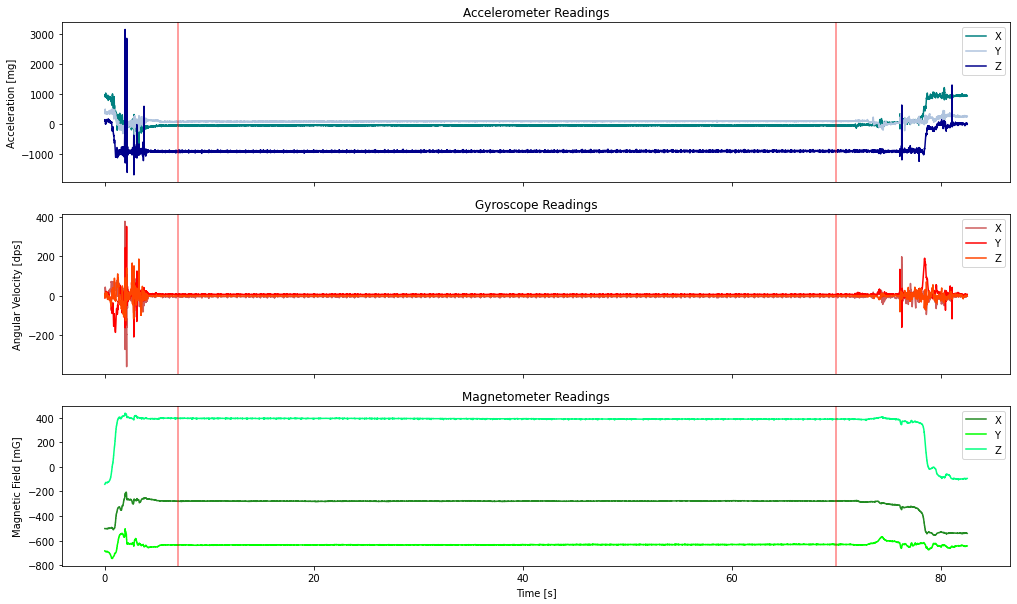

In [9]:
(fig, (ax1,ax2,ax3)) = plt.subplots(3,1,figsize=(17,10), sharex=True)

ax1.set_title('Accelerometer Readings')
ax1.plot(df['Time'], df['AccX'], color= 'teal',label='X')
ax1.plot(df['Time'], df['AccY'], color= 'lightsteelblue',label='Y')
ax1.plot(df['Time'], df['AccZ'], color= 'darkblue',label='Z')
ax1.axvline(x = 7, color = 'red', alpha = 0.5)
ax1.axvline(x = 70, color = 'red', alpha = 0.5)
ax1.set_ylabel('Acceleration [mg]')
ax1.legend()

ax2.plot(df['Time'], df['GyroX'],color = 'indianred', label='X')
ax2.plot(df['Time'], df['GyroY'],color = 'red' , label='Y')
ax2.plot(df['Time'], df['GyroZ'],color = 'orangered' , label='Z')
ax2.set_title('Gyroscope Readings')
ax2.axvline(x = 7, color = 'red', alpha = 0.5)
ax2.axvline(x = 70, color = 'red', alpha = 0.5)
ax2.set_ylabel('Angular Velocity [dps]')
ax2.legend()

ax3.plot(df['Time'], df['MagnX'],color = 'forestgreen' , label='X')
ax3.plot(df['Time'], df['MagnY'], color = 'lime', label='Y')
ax3.plot(df['Time'], df['MagnZ'], color = 'springgreen', label='Z')
ax3.set_title('Magnetometer Readings')
ax3.axvline(x = 7, color = 'red', alpha = 0.5)
ax3.axvline(x = 70, color = 'red', alpha = 0.5)
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Magnetic Field [mG]') 
ax3.legend()

plt.show()

In [10]:
#empty cell, do not delete, just edit

In [11]:
#empty cell, do not delete, just edit

In [12]:
#empty cell, do not delete, just edit

## Remove unimportant columns and limit time between thresholds

In [13]:
# Cut the misleading rows
df_timecut = df.loc[(df['Time'] >= 7) & (df['Time'] <= 70)] #limit analysis in specified time frame

# Select the columns we need for the PCA
df_time_frame = df_timecut.drop(['Log Mode', 'Log Freq', 'Timestamp', 'Time'], axis=1) #drop uninmportant columns
display(df_time_frame)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
1400,-40.966811,97.029054,-875.184185,-3.845277,6.826058,-1.466489,-280.758336,-636.976552,394.773322
1401,-34.987088,86.098363,-919.513010,-3.723140,6.642852,-1.909237,-279.862302,-636.084927,394.781061
1402,-40.518149,94.134202,-895.697231,-3.692606,6.993997,-1.603893,-279.862302,-636.084927,394.781061
1403,-35.181772,86.193470,-903.405417,-3.417797,7.207738,-1.802366,-280.801358,-635.142542,395.656637
1404,-31.341134,88.631706,-903.044484,-3.555201,7.268807,-1.985573,-280.801358,-635.142542,395.656637
...,...,...,...,...,...,...,...,...,...
13996,-34.443708,104.012984,-884.386623,-5.417797,6.322242,-1.497023,-277.245071,-631.610104,388.689191
13997,-36.395733,103.541515,-885.425685,-5.234590,6.642852,-1.268015,-277.245071,-631.610104,388.689191
13998,-26.245083,99.049690,-891.489056,-5.265125,6.749723,-1.283282,-278.117853,-633.416605,388.677195
13999,-42.264295,104.980254,-880.401686,-5.097186,6.383310,-1.603893,-278.117853,-633.416605,388.677195


In [14]:
#empty cell, do not delete, just edit

In [15]:
#empty cell, do not delete, just edit

In [16]:
#empty cell, do not delete, just edit

# STATISTICAL QUANTITIES

In these cells I've displayed the statistical quantities and centered the data. Ideally we would now apply a PCA procedure on the dataset

In [17]:
statistics = pd.DataFrame({
    'mean'  : df_time_frame.mean(),
    'median': df_time_frame.median(),
    'variance': df_time_frame.var(),
    'standard deviation': df_time_frame.std(),
    '25% percentile' : df_time_frame.quantile(q=0.25),
    '75% percentile': df_time_frame.quantile(q=0.75)}).T

display(statistics)

centered_df = (df_time_frame - statistics.iloc[0])

standardized_df = centered_df/statistics.iloc[3]

display(standardized_df)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
mean,-34.301107,100.672668,-892.751709,-4.328942,6.645621,-1.585198,-278.673423,-633.734049,391.232698
median,-34.255264,100.925927,-893.136026,-4.394896,6.597051,-1.573359,-278.966269,-633.422827,391.289599
variance,50.283779,30.225341,214.154767,2.100338,0.538998,0.156231,1.445253,3.157548,6.844151
standard deviation,7.091106,5.497758,14.634028,1.449254,0.734165,0.395261,1.202187,1.776949,2.616133
25% percentile,-38.951062,97.261279,-901.522903,-4.944514,6.230639,-1.832901,-279.106893,-635.187081,388.689191
75% percentile,-29.585315,104.273711,-884.748964,-3.707873,6.963463,-1.329084,-278.050465,-632.478477,393.908965


,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
1400,-0.940009,-0.662745,1.200457,0.333734,0.245772,0.300333,-1.734266,-1.824758,1.353381
1401,-0.096738,-2.650954,-1.828704,0.418009,-0.003771,-0.819810,-0.988930,-1.322986,1.356339
1402,-0.876738,-1.189297,-0.201279,0.439078,0.474521,-0.047297,-0.988930,-1.322986,1.356339
1403,-0.124193,-2.633655,-0.728009,0.628699,0.765655,-0.549429,-1.770053,-0.792647,1.691023
1404,0.417421,-2.190159,-0.703345,0.533889,0.848837,-1.012938,-1.770053,-0.792647,1.691023
...,...,...,...,...,...,...,...,...,...
13996,-0.020110,0.607578,0.571619,-0.751321,-0.440472,0.223082,1.188128,1.195276,-0.972239
13997,-0.295388,0.521821,0.500616,-0.624906,-0.003771,0.802466,1.188128,1.195276,-0.972239
13998,1.136074,-0.295207,0.086282,-0.645976,0.141797,0.763840,0.462133,0.178646,-0.976825
13999,-1.122983,0.783517,0.843925,-0.530096,-0.357292,-0.047297,0.462133,0.178646,-0.976825


In [18]:
#empty cell, do not delete, just edit

In [19]:
#empty cell, do not delete, just edit

In [20]:
#empty cell, do not delete, just edit

# PCA

In [21]:
import scipy.linalg as la

cov = np.cov(standardized_df.T) 
print('Covariance matrix is: \n')
print(cov)
l, V = la.eig(cov)
print('\n')
print(np.real_if_close(l))

var = []
for i in range(len(l)):
    var.append(np.real_if_close(l[i]/l.sum()))
for i in range(len(var)):
    print('The direction described by the eigenvector', V[:,i], 'with eigenvalue', np.round(np.real_if_close(l[i]),5), 'accounts for', np.round(var[i]*100,5), '% of the dataset variance.')

Covariance matrix is: 

[[ 1.         -0.18258906 -0.40534598  0.21207383  0.00694783  0.02527068
  -0.37884531 -0.02223932  0.07132795]
 [-0.18258906  1.          0.17543359 -0.05200114  0.00194328 -0.10264916
   0.24296646  0.35545905 -0.49314663]
 [-0.40534598  0.17543359  1.         -0.07794268  0.11182493  0.0170906
   0.12428012  0.20368083 -0.24995133]
 [ 0.21207383 -0.05200114 -0.07794268  1.          0.39781266  0.35024432
  -0.06030483 -0.05649073  0.02298868]
 [ 0.00694783  0.00194328  0.11182493  0.39781266  1.          0.42702172
   0.01283499 -0.12856827  0.02335776]
 [ 0.02527068 -0.10264916  0.0170906   0.35024432  0.42702172  1.
  -0.00701684 -0.07065322  0.01202646]
 [-0.37884531  0.24296646  0.12428012 -0.06030483  0.01283499 -0.00701684
   1.          0.22430539 -0.31617861]
 [-0.02223932  0.35545905  0.20368083 -0.05649073 -0.12856827 -0.07065322
   0.22430539  1.         -0.74628961]
 [ 0.07132795 -0.49314663 -0.24995133  0.02298868  0.02335776  0.01202646
  -0.31

In [22]:
#empty cell, do not delete, just edit

In [23]:
#empty cell, do not delete, just edit

In [24]:
#empty cell, do not delete, just edit

## Now we rotate the data in the new base, thus taking a linear combination of physical quantities.

In [25]:
rotated_data = np.dot(V.T, standardized_df.T) #bring the dataset in the eigenvector basis
dataset_rotated = pd.DataFrame(rotated_data.T, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'])

# Find out how many columns of the PCA we can drop while keeping 80% of the info
idx = np.argsort(l)[::-1]  # sort the eigenvalues and eigenvectors
l_sort = l[idx]
V_sort = V[idx]

S, i = 0, 0
tr = l.sum()
while np.real_if_close(S/tr) < 0.8:
    S += l_sort[i]
    i += 1
print("Reduction of the number of PC and its accuracy:")
print(np.round(np.real_if_close(S/tr)*100, 2), '%, number of PC = ', i)

Reduction of the number of PC and its accuracy:
80.4 %, number of PC =  5


In [26]:
dataset_rotated = dataset_rotated.drop(['PC6','PC7', 'PC8', 'PC9'], axis = 1)
display(dataset_rotated)

,PC1,PC2,PC3,PC4,PC5
0,-1.928588,0.094264,1.890466,-0.372843,-1.679231
1,-3.258919,-1.108153,0.213514,-0.491081,0.552758
2,-2.091999,-0.047004,1.327826,-0.148701,-0.343500
3,-3.253622,-0.324565,0.464058,0.119705,-0.795915
4,-3.145178,-0.534853,0.063261,0.219781,-0.845051
...,...,...,...,...,...
12596,2.045979,-0.060172,-0.213564,0.252003,0.271711
12597,1.926365,0.564832,0.025205,0.262983,0.341211
12598,0.329365,0.378792,-0.758031,-0.500639,0.044745
12599,1.767136,-0.140338,0.767162,-0.488203,-0.189476


In [27]:
#empty cell, do not delete, just edit

In [28]:
#empty cell, do not delete, just edit

## By using the first 5 principal componenets we retain around 80% of the variability --> We now apply FFT and look for the peaks of each principal component.

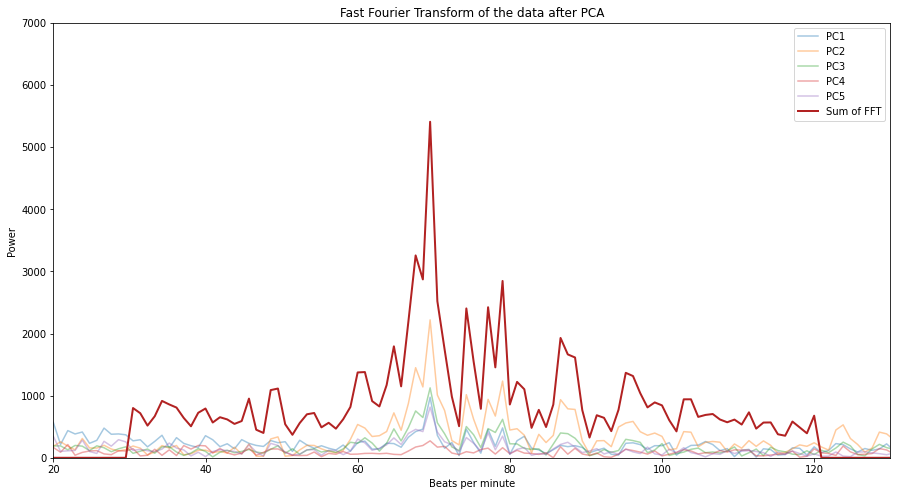

Highest peak is at: 69.52 beats per minute


In [29]:
#from scipy import signal

sample_freq = 200

# FFT
FFTs = {} # create a dictionary to store the FFT of each PC
for i in dataset_rotated:
    FFTs[i] = np.abs(np.fft.rfft(dataset_rotated[i]))

freq_FFT = np.fft.rfftfreq(d = 1/sample_freq, n = len(dataset_rotated['PC1']))

# The heartbeat is given by the sum of the different components
total_FFT = np.array(FFTs['PC1'] + FFTs['PC2'] + FFTs['PC3'] + FFTs['PC4'] + FFTs['PC5'])

# Set frequency limits
min_f = 30/60  #minimum for athletes is 30 beats per minute
max_f = 120/60 #maximum (sustainable) is around 120 beats per minimum
total_FFT[freq_FFT >= max_f] = 0
total_FFT[freq_FFT <= min_f] = 0

# Plot the frequencies
fig2, ax1 = plt.subplots(figsize=(15, 8))
for i in FFTs:
    ax1.plot(freq_FFT*60, FFTs[i], label=i, alpha = 0.4)
ax1.plot(freq_FFT*60, total_FFT, label='Sum of FFT', color = 'firebrick', linewidth = 2)
ax1.set_xlim([min_f*60-10, max_f*60+10])
ax1.set_ylim([0, 7000])
ax1.set_xlabel('Beats per minute')
ax1.set_ylabel('Power')
ax1.set_title('Fast Fourier Transform of the data after PCA')
ax1.legend()
plt.show()

# Also filter frequecies for the individual FFTs in case we need them:
for i in dataset_rotated:
    FFTs[i][freq_FFT <= min_f] = 0
    FFTs[i][freq_FFT >= max_f] = 0

# Find the value of the highest peak
idx_max = np.argmax(total_FFT)
peak_freq = freq_FFT[idx_max]*60
print("Highest peak is at:", np.round(peak_freq,2), "beats per minute")

In [30]:
dataset_rotated['Time'] = np.arange(0, len(dataset_rotated['PC1']))/sample_freq

In [31]:
# C) nico empty cell, do not delete, just edit

In [32]:
# D) marco empty cell, do not delete, just edit

# FILTER

## (a) Directly from Fourier Analysis, antitrasform data looking for the most interesting frequency band. 

## --> I DON'T THINK THIS IS CORRECT, BECAUSE WE WOULD BE ONLY TAKING INTO ACCOUNT ONE OF THE FREQUENCIES, THE MOST COMMON ONE, AND DISMISSING THE REST. I LEAVE THE CODE IN CASE IS USEFUL FOR LATER THINGS.

In [33]:
#empty cell, do not delete, just edit

## (b) Choose the appropriate Lowpass/Bandpass/Highpass filter.

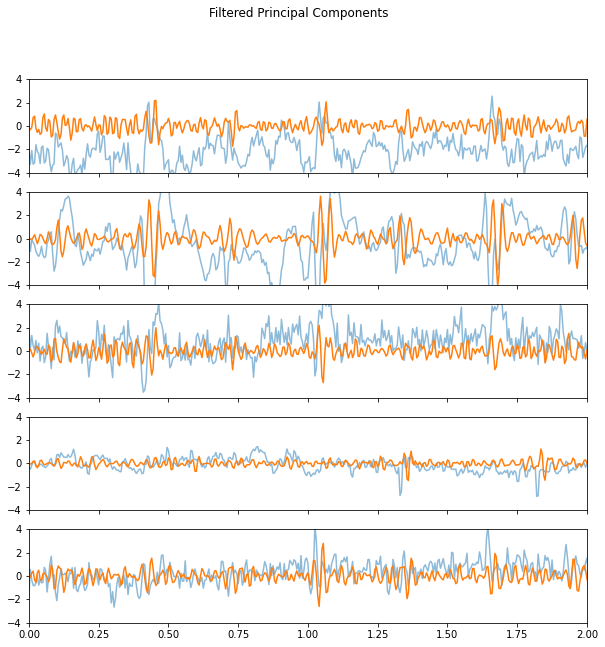

In [34]:
from scipy import signal
#used sos instead of "standard output" (i.e. 'ba representation' is numerically garbage at high orders.
#Even relatively low order filters can have problems when desired bandwidth is small compared to the sampling frequency)


sos = signal.butter(4, [40,120], 'bp', fs = 400, output = 'sos')

filtered_PC1 = signal.sosfilt(sos, dataset_rotated['PC1'])
filtered_PC2 = signal.sosfilt(sos, dataset_rotated['PC2'])
filtered_PC3 = signal.sosfilt(sos, dataset_rotated['PC3'])
filtered_PC4 = signal.sosfilt(sos, dataset_rotated['PC4'])
filtered_PC5 = signal.sosfilt(sos, dataset_rotated['PC5'])


fig, axs = plt.subplots(5,1, sharex=True, sharey=True, figsize=(10,10))
fig.suptitle('Filtered Principal Components')
axs[0].plot(dataset_rotated['Time'], dataset_rotated['PC1'], alpha = 0.5)
axs[0].plot(dataset_rotated['Time'], filtered_PC1)
axs[1].plot(dataset_rotated['Time'], dataset_rotated['PC2'], alpha = 0.5)
axs[1].plot(dataset_rotated['Time'], filtered_PC2)
axs[2].plot(dataset_rotated['Time'], dataset_rotated['PC3'], alpha = 0.5)
axs[2].plot(dataset_rotated['Time'], filtered_PC3)
axs[3].plot(dataset_rotated['Time'], dataset_rotated['PC4'], alpha = 0.5)
axs[3].plot(dataset_rotated['Time'], filtered_PC4)
axs[4].plot(dataset_rotated['Time'], dataset_rotated['PC5'], alpha = 0.5)
axs[4].plot(dataset_rotated['Time'], filtered_PC5)
for i,axes in enumerate(axs):
    axs[i].set_xlim([0,2])
    axs[i].set_ylim([-4,4])


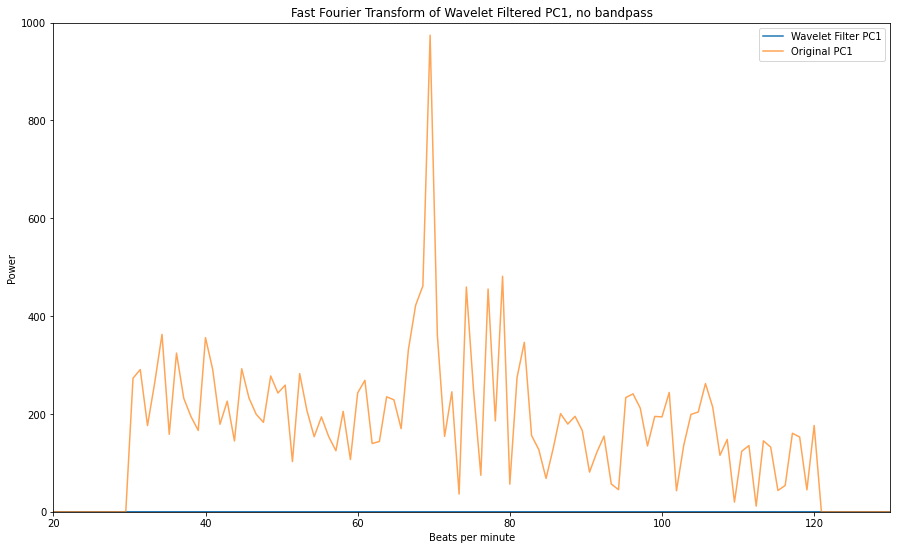

In [35]:
testplot = np.abs(np.fft.rfft(filtered_PC1))

plt.figure(figsize=(15, 9))
plt.plot(freq_FFT*60, testplot, label='Wavelet Filter PC1')
plt.plot(freq_FFT*60, FFTs['PC1'], label='Original PC1', alpha=0.7)
plt.xlim([min_f*60-10, max_f*60+10])
plt.ylim([0, 1000])
plt.xlabel('Beats per minute')
plt.ylabel('Power')
plt.title('Fast Fourier Transform of Wavelet Filtered PC1, no bandpass')
plt.legend()
plt.show()

In [36]:
#empty cell, do not delete, just edit

In [37]:
#empty cell, do not delete, just edit

## (c) Wavelet trasform (a powerfull instrument that make a time and frequency analysis of signal).

In [38]:
from scipy import signal
import pywt
import copy

/home/kabo/.local/lib/python3.8/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 12 is too high: all coefficients will experience boundary effects.
  warnings.warn(


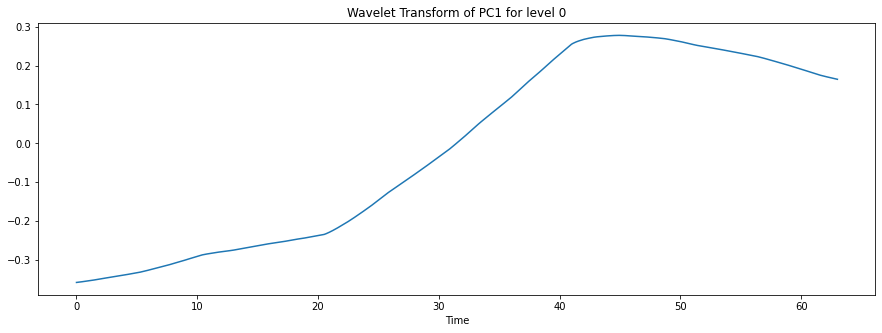

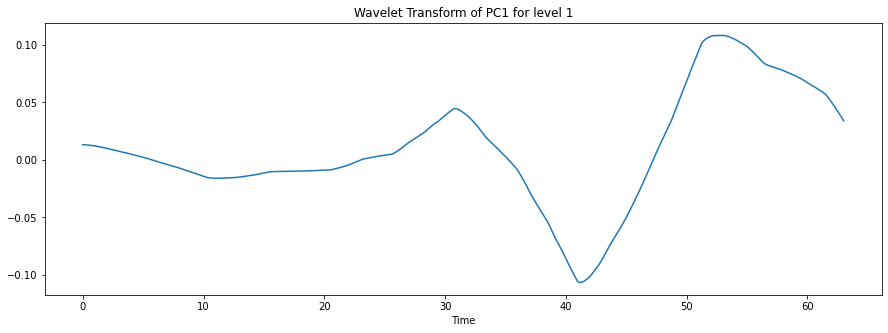

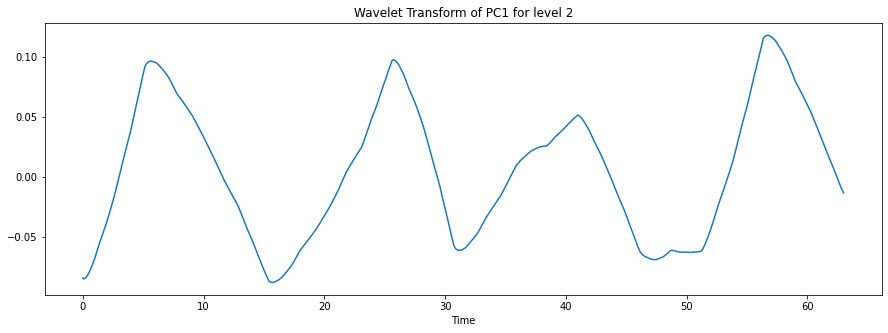

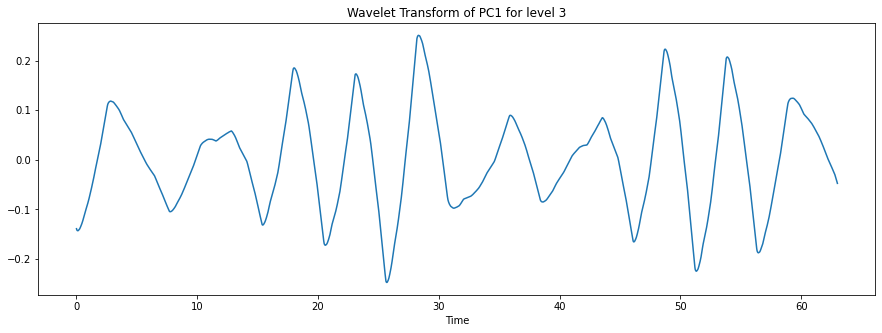

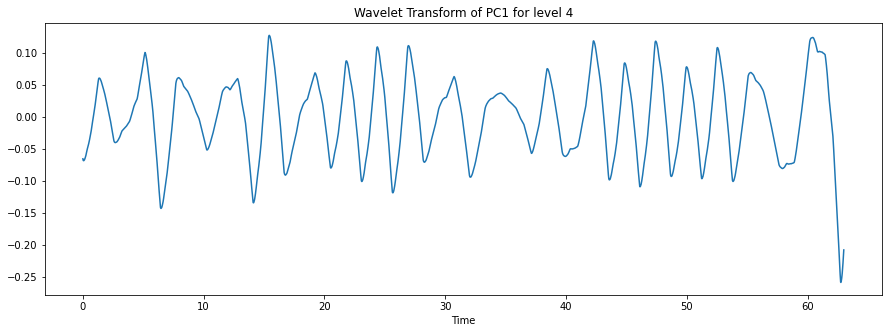

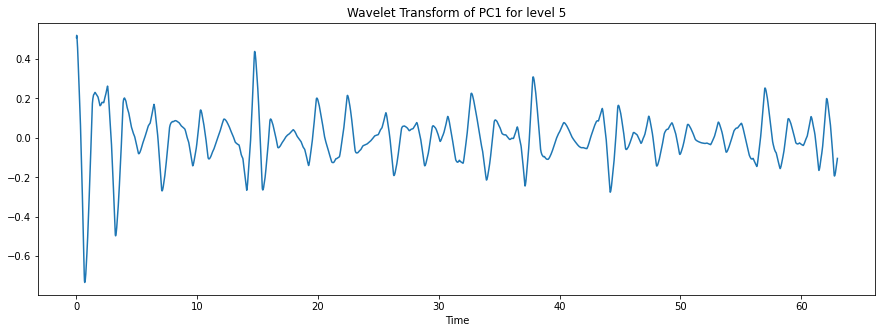

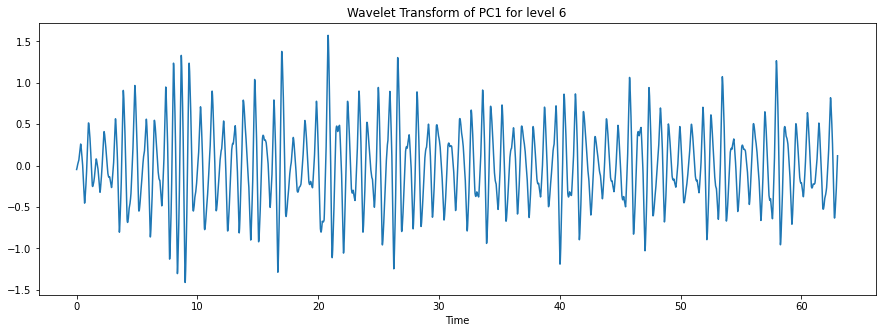

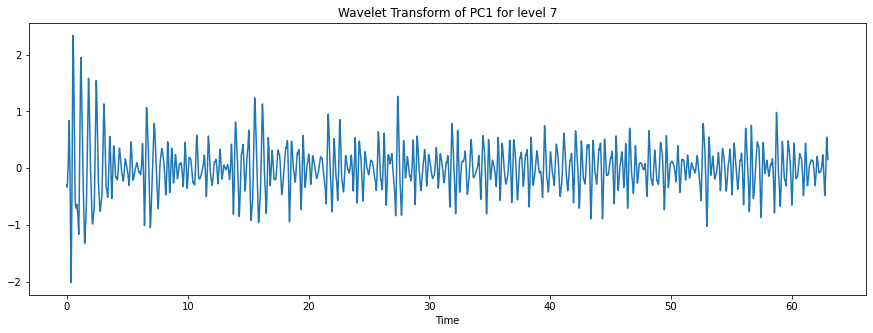

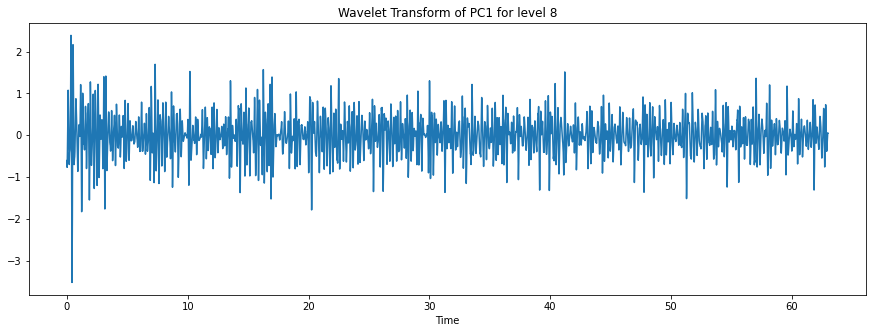

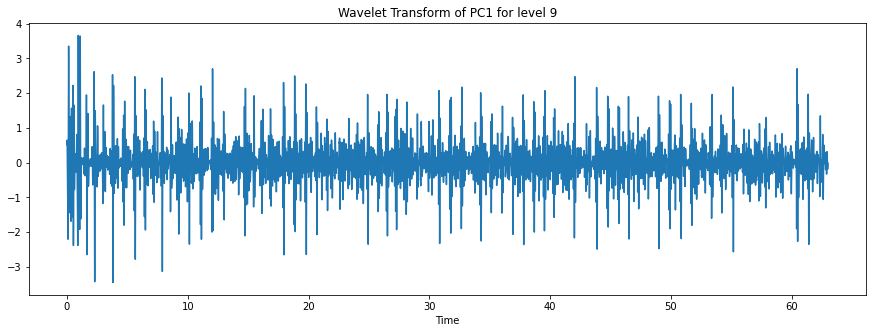

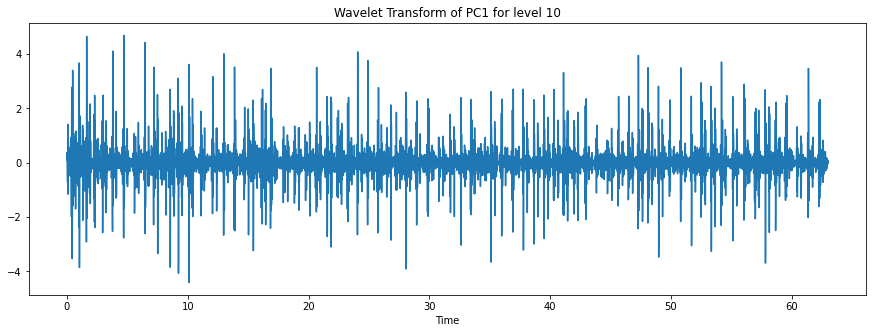

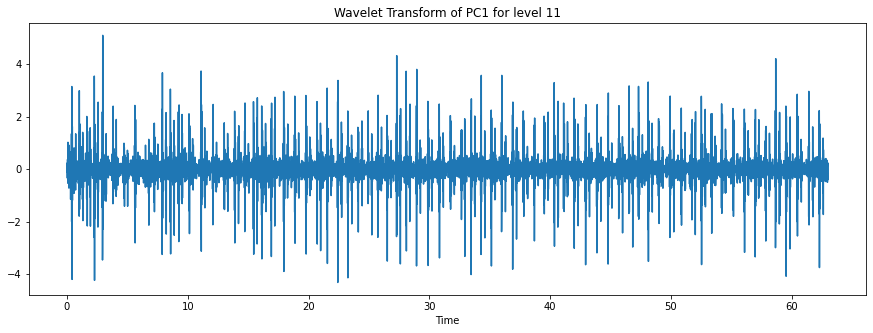

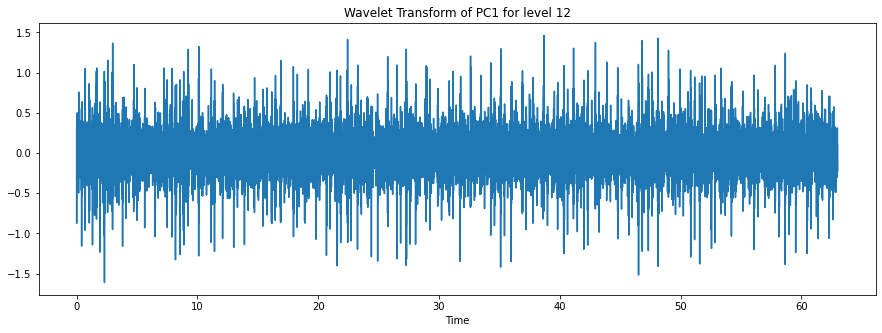

In [39]:
def wavelet_transform(signal, levels, waveletType, showWaveletScales):
    # first do the transform using the input signal with the wavelet type and levels inputed
    transformCoeffs = pywt.wavedec(signal, waveletType, level=levels)
    
    # Create a time array and a result array
    time = np.array(dataset_rotated['Time'])
    result = np.zeros((levels+1, len(time)+1))
    
    # Loop for every level 
    for i in range(levels+1):
        coeffs = copy.deepcopy(transformCoeffs)
        
        for j in range(levels+1):
            # Loop over every other level and set to zero
            if(i!=j):
                coeffs[j] = np.zeros_like(coeffs[j])
        
        #add the inverse wavelet of the level i to the corresponding result row
        result[i] = pywt.waverec(coeffs, waveletType)
        
    # Option to visualize the wavelet scale decomposition
    if showWaveletScales == True:
        for level in range(levels+1):
            # Plot each level
            plt.figure(figsize=(15, 5))
            plt.plot(time, result[level][:-1])
            plt.title(f'Wavelet Transform of PC1 for level {level}')
            plt.xlabel('Time')
            plt.show()
        
    return transformCoeffs    
    '''Do transform, loop over every level and set all other levels to zero and add to the final 
        coefficients array, removing noise from other leverls. Then loop through each level again 
        and plot the inverse wavelet. 
        
    '''

waveletPC1 = wavelet_transform(np.array(dataset_rotated['PC2']), 12, 'sym4', True)

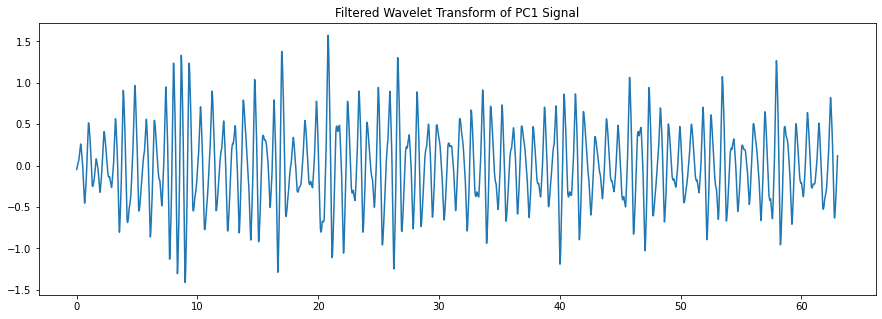

In [40]:
def waveletFilter(coeffs, indices, waveletType):
    for level in range(len(coeffs)):
        if level in indices:
            coeffs[level] = np.zeros_like(coeffs[level])
    return pywt.waverec(coeffs, waveletType)

# Filter the wavelet transform of PC1 by ignoring the noisy levels 
# and just choosing levels we want
waveFiltered_PC1 = waveletFilter(waveletPC1, [0,1,2,3,4,5,7,8,9,10,11,12], 'sym4')
time = np.array(dataset_rotated['Time'])
plt.figure(figsize=(15, 5))
plt.plot(time, waveFiltered_PC1[:-1])
plt.title('Filtered Wavelet Transform of PC1 Signal')
plt.show()

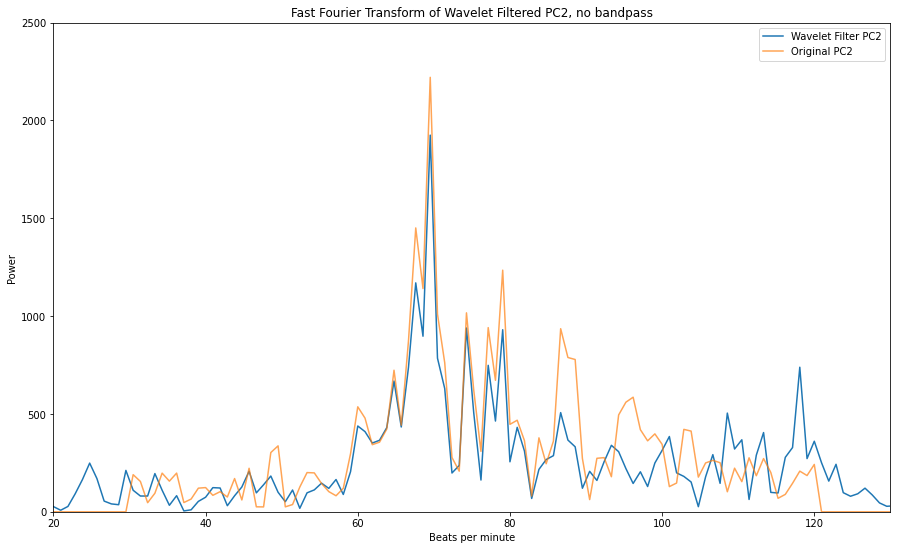

In [41]:
## Now we can fft this to find peaks
filtered_PC1_fft = np.abs(np.fft.rfft(waveFiltered_PC1))

plt.figure(figsize=(15, 9))
plt.plot(freq_FFT*60, filtered_PC1_fft[:-1], label='Wavelet Filter PC2')
plt.plot(freq_FFT*60, FFTs['PC2'], label='Original PC2', alpha=0.7)
plt.xlim([min_f*60-10, max_f*60+10])
plt.ylim([0, 2500])
plt.xlabel('Beats per minute')
plt.ylabel('Power')
plt.title('Fast Fourier Transform of Wavelet Filtered PC2, no bandpass')
plt.legend()
plt.show()

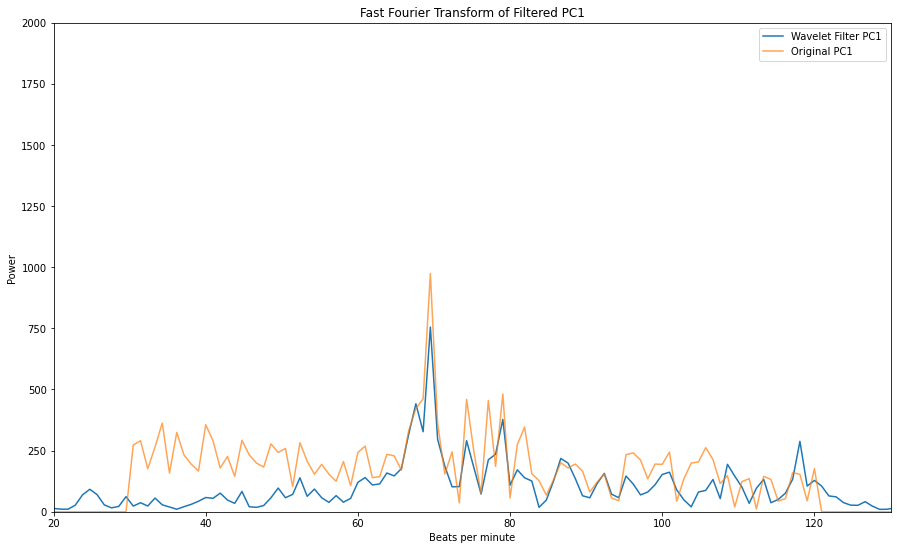

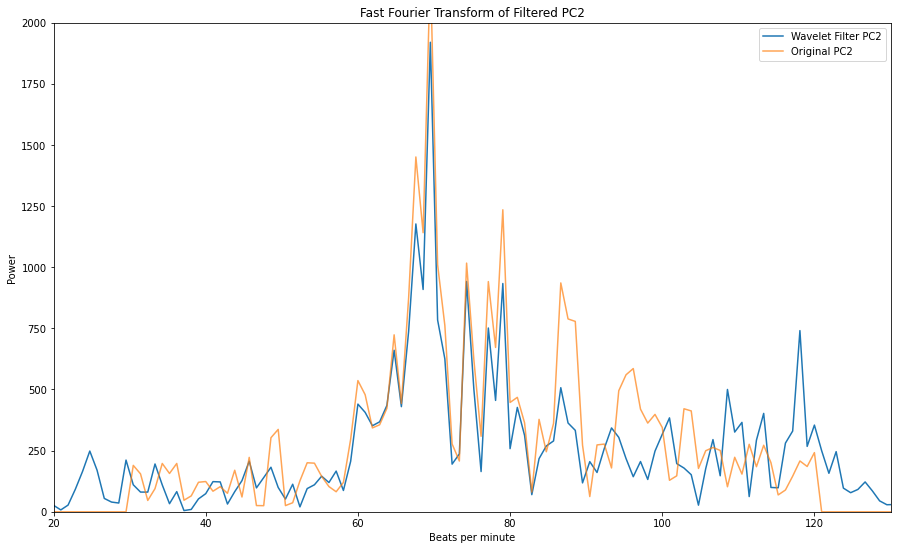

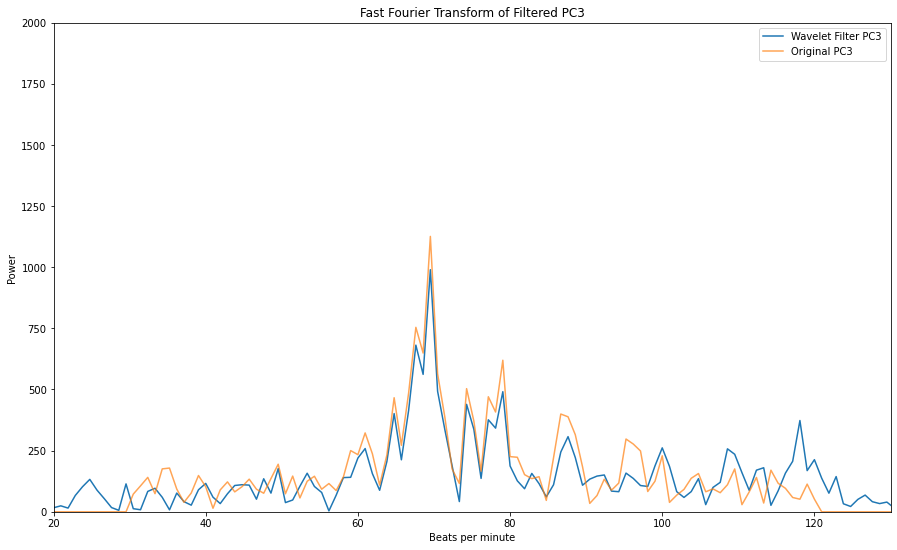

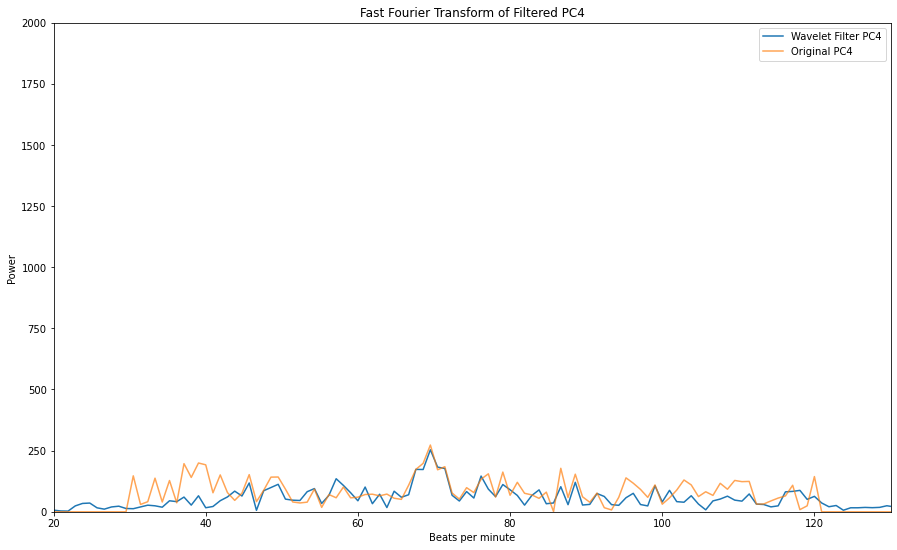

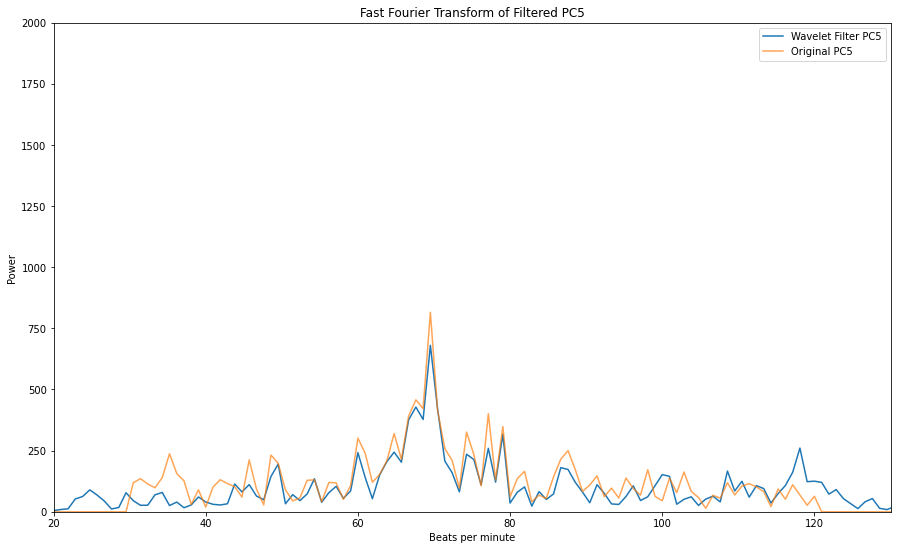

In [42]:
# Pipeline Filter function
def filterSignal(sig):
    from scipy import signal
    
    # Passes a signal through a bandpass and wavelet filter and returns the filtered signal
    #bandpass = signal.sosfilt(sos, sig)
    wavelet = wavelet_transform(np.array(sig), 10, 'sym4', False)
    wavelet_filtered = waveletFilter(wavelet, [0,1,2,3,5,6,7,8,9,10], 'sym4')
    #bandpass = signal.sosfilt(sos, wavelet_filtered)
        
    return wavelet_filtered[:-1]
    #return bandpass

def plotFilteredSignal(filteredSignal, i):
    filtered_fft = np.abs(np.fft.rfft(filteredSignal))
    
    # Plots the fft of the input filtered signal 
    plt.figure(figsize=(15, 9))
    plt.plot(freq_FFT*60, filtered_fft, label=f'Wavelet Filter {i}')
    plt.plot(freq_FFT*60, FFTs[i], label=f'Original {i}', alpha=0.7)
    plt.xlim([min_f*60-10, max_f*60+10])
    plt.ylim([0, 2000])
    plt.xlabel('Beats per minute')
    plt.ylabel('Power')
    plt.title(f'Fast Fourier Transform of Filtered {i}')
    plt.legend()
    plt.show()

    
for i in FFTs:
    #For each Principcal Component, filter the signal and plot
    pc = filterSignal(dataset_rotated[i])
    plotFilteredSignal(pc, i)

In [43]:
#empty cell, do not delete, just edit

## (d) Find another method by yourselves.

In [44]:
#empty cell, do not delete, just edit

In [45]:
#empty cell, do not delete, just edit

In [46]:
#empty cell, do not delete, just edit

In [47]:
#empty cell, do not delete, just edit

In [48]:
#empty cell, do not delete, just edit

In [49]:
#empty cell, do not delete, just edit

## Motivate your choice.

In [50]:
#empty cell, do not delete, just edit

In [51]:
#empty cell, do not delete, just edit

In [52]:
#empty cell, do not delete, just edit

In [53]:
#empty cell, do not delete, just edit

In [54]:
#empty cell, do not delete, just edit

In [55]:
#empty cell, do not delete, just edit

# METRICS

## 4.1. Heart Beat Per Minute(BPM): extrapolate BPM, make an histogram of the result. Does it follow a partiular distribution? 

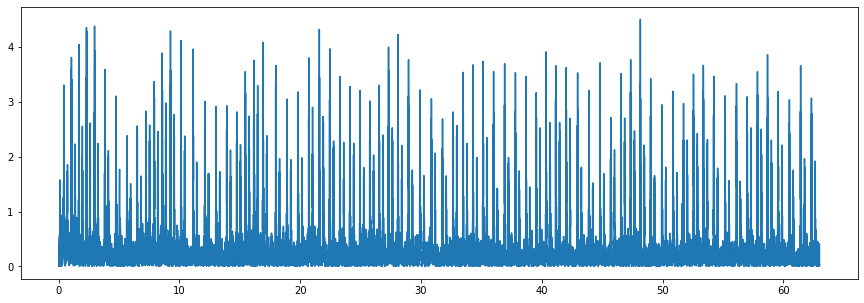

In [56]:
# I use not filtered PC2, but the idea is using the data after the wavelet


fig = plt.figure(figsize=(15,5))
plt.plot(np.array(dataset_rotated['Time']), np.abs(filtered_PC2))



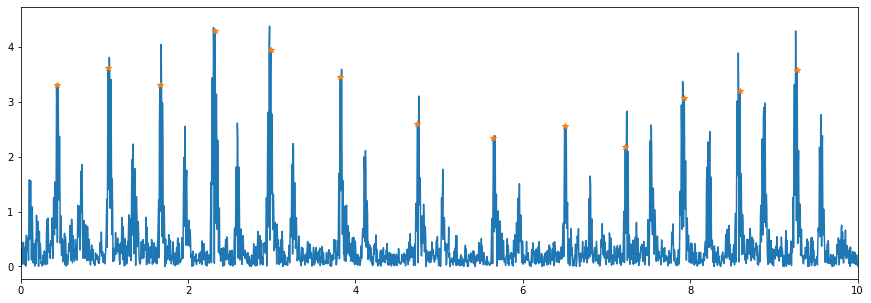

In [57]:


# Find the peaks in the filtered data
peaks = signal.find_peaks(filtered_PC2, height = 1, distance = 100)
# height: minimum height of a measured peak
# distance: minimum number of indexes between measured peaks.
# Each step 0.005secs --> min time between peaks 1/120*60 = 0.5s (max freq) --> should be d = 100

# Given the peak indexes, find corresponding time and height
def peak_points(indices, time, signl):
    x_peaks = []
    y_peaks = []
    for i in indices:
        x_peaks.append(time[i])
        y_peaks.append(signl[i])
    return np.array(x_peaks), np.array(y_peaks)

time_PC2, PC2_peaks = peak_points(peaks[0], np.array(dataset_rotated['Time']), filtered_PC2)

# Plot
fig = plt.figure(figsize=(15,5))
plt.plot(np.array(dataset_rotated['Time']), np.abs(filtered_PC2))
plt.xlim([0,10])
plt.plot(time_PC2, PC2_peaks, '*')
#empty cell, do not delete, just edit



In [58]:
# We should filter the points that are valuable and estimate the periodicity between peaks
# we said highest possible frequency = 120bpm, therefore it is only reasonable
# that there is a peak at least every 1/120*60 seconds = 0.5s

# This function does the same the find_peaks did automatically with the distance, i didnt know it did that at the time :D
def time_frame(t, a, b):
    # break if it is out of bounds of time
    if b > (len(t)-1): return 0, 0
    measure = (t[b] - t[a])
    if measure > 0.5:
        return measure, b
    else:
        b += 1
        return time_frame(t, a, b)

periodicity = []
time_beat = []
b = 0
for i in range(len(time_PC2)):
    if i == b:
        p, b = time_frame(time_PC2, i, (i+1))
        periodicity.append(p)
        time_beat.append((time_PC2[b]+time_PC2[i])/2)
periodicity.pop()
time_beat.pop()
# Heart beat frequency is the inverse of the periodicity time
HB_values = 1/np.array(periodicity)*60
#print(HB_values, np.array(time_beat))


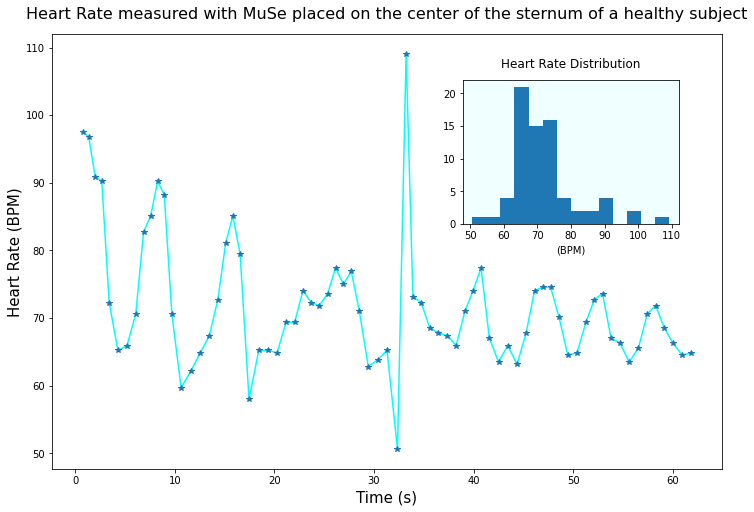

In [59]:
#empty cell, do not delete, just edit
fig = plt.figure(figsize = (12,8))
plt.plot(time_beat, HB_values, color = 'cyan')
plt.plot(time_beat, HB_values, '*')
plt.title('Heart Rate measured with MuSe placed on the center of the sternum of a healthy subject', pad = 15, fontsize = 16)
plt.ylabel('Heart Rate (BPM)', fontsize = 15)
plt.xlabel('Time (s)', fontsize = 15)
a = plt.axes([.6, .55, .25, .25], facecolor='azure')
n, bins, patches = plt.hist(HB_values, 14)
plt.title('Heart Rate Distribution', pad = 12)
plt.xlabel('(BPM)')
plt.show()



In [60]:
#empty cell, do not delete, just edit

In [61]:
#empty cell, do not delete, just edit

## 4.2. Heart Rate Variability(HRV): extrapolate HRV, explain why this parameter is important, and plot the results.

In [62]:
#empty cell, do not delete, just edit

In [63]:
#empty cell, do not delete, just edit

In [64]:
#empty cell, do not delete, just edit

In [65]:
#empty cell, do not delete, just edit

In [66]:
#empty cell, do not delete, just edit

In [67]:
#empty cell, do not delete, just edit

# (OPTIONAL) Algorithm: Elaborate a simple algorithm to extrapolate heart beat even when filter failed (e.g. look at particular threshold...).

In [68]:
#empty cell, do not delete, just edit

In [69]:
#empty cell, do not delete, just edit

In [70]:
#empty cell, do not delete, just edit

In [71]:
#empty cell, do not delete, just edit

In [72]:
#empty cell, do not delete, just edit

In [73]:
#empty cell, do not delete, just edit

# CONCLUSIONS

In [74]:
#empty cell, do not delete, just edit

In [75]:
#empty cell, do not delete, just edit

In [76]:
#empty cell, do not delete, just edit

In [77]:
#empty cell, do not delete, just edit

In [78]:
#empty cell, do not delete, just edit

In [79]:
#empty cell, do not delete, just edit